In [1]:
import torch
import torch.nn as nn
import torchvision as vision
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import PIL
import numpy as np
from matplotlib import pyplot as plt
from IPython.core import debugger

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [3]:
#Load COCO Dataset
comptransf4us = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        #normalize,
    ])

comptransf4vgg = transforms.Compose([
        transforms.Resize((1024,1024)),
        transforms.ToTensor(),
        #normalize,
    ])

coco = vision.datasets.ImageFolder('/datasets/', transform=comptransf4us)


In [4]:
def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std


In [5]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, filters, kernel_size=3, stride=1, padding=0):
        super(ResidualBlock, self).__init__()
        self.ksize = kernel_size
        self.conv1 = nn.Conv2d(filters, filters, kernel_size, stride, padding)
        #self.bn1 = nn.BatchNorm2d(filters)
        self.in1 = nn.InstanceNorm2d(filters, affine=True)
        self.conv2 = nn.Conv2d(filters, filters, kernel_size, stride, padding)
        #self.bn2 = nn.BatchNorm2d(filters)
        self.in2 = nn.InstanceNorm2d(filters, affine=True)
        

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.in1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.in2(out)
        out += F.pad(residual, (-2, -2, -2, -2))
        return out
                                                 
class UpsampleConvLayer(nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


In [6]:
class TransformNet(nn.Module):
    
    def __init__(self):
        super(TransformNet, self).__init__()
        
        self.reflectPadding2D = nn.ReflectionPad2d(40)
        self.conv1 = nn.Conv2d(3, 32, 9, padding=4)
        #self.bn1 = nn.BatchNorm2d(32)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        #self.bn2 = nn.BatchNorm2d(64)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        #self.bn3 = nn.BatchNorm2d(128)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        #self.bn_deconv1 = nn.BatchNorm2d(64)
        self.in_deconv1 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        #self.bn_deconv2 = nn.BatchNorm2d(32)
        self.in_deconv2 = nn.InstanceNorm2d(32, affine=True)
        self.outputConv = nn.Conv2d(32, 3, 9, padding=4)
        
        
    def forward(self, x):
        
        x = self.reflectPadding2D(x)
        x = F.relu(self.in1(self.conv1(x)))
        x = F.relu(self.in2(self.conv2(x)))
        x = F.relu(self.in3(self.conv3(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = F.relu(self.in_deconv1(self.deconv1(x)))
        x = F.relu(self.in_deconv2(self.deconv2(x)))
        x = (F.tanh(self.outputConv(x))+1)*127.5
        
        return x
        

In [7]:
def normalizeTensor(x):
    assert type(x) == torch.Tensor
    minim = torch.min(x)
    maxim = torch.max(x)
    
    return (x - minim)/(maxim - minim)

In [8]:
vgg = vision.models.vgg16(pretrained=True).features.cuda()

for param in vgg.parameters():
    
    param.requires_grad = False

In [9]:
def VGGRead(path, s1 = 1024, s2 = 1024, normalizer=True):
    assert type(path) == str
    testimage = PIL.Image.open(path)
    
    if normalizer:
        comptransf4vgg = transforms.Compose([
            transforms.Resize((s1,s2)),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        comptransf4vgg = transforms.Compose([
            transforms.Resize((s1,s2)),
            transforms.ToTensor()
        ])


    
    testimage = comptransf4vgg(testimage).cuda()
        
    return testimage.unsqueeze(0)


In [10]:
def gram_matrix(x):
    """
    returns N x C x C gram matrices of N x C x W x H batches
    """
    assert len(x.shape) == 4 #we're working on batches N x C x W x H
    N, C, W, H = x.shape
    
    batch_of_grams = torch.empty((N, C, C), device='cuda:0')
    
    for idx, batch_item in enumerate(x):
        
        #assert batch_item.requires_grad
        
        batch_item = batch_item.reshape(C, W*H)
        
        gram_matrix = torch.matmul(batch_item, batch_item.transpose(0, 1))
        
        batch_of_grams[idx] = gram_matrix
        
    batch_of_grams /= (C*W*H)
    return batch_of_grams

In [11]:
def get_style_grams(style_image):
    """style_image(string) -> path to Style Image"""
    
    style_image = VGGRead(style_image, s1=224, s2=224)
    
    outputs = []
    hooks = []
    def hook(module, input, output):
        outputs.append(output)

    hooks += [vgg[3].register_forward_hook(hook)]
    hooks += [vgg[8].register_forward_hook(hook)]
    hooks += [vgg[15].register_forward_hook(hook)]
    hooks += [vgg[22].register_forward_hook(hook)]
    
    vgg(style_image)
    
    [i.remove() for i in hooks]
    
    relu1_2, relu2_2, relu3_3, relu4_3 = outputs
        
    
    
    return gram_matrix(relu1_2)[0], gram_matrix(relu2_2)[0], gram_matrix(relu3_3)[0], gram_matrix(relu4_3)[0]


In [12]:
def loss_function(input_of_net, output_of_net, style_gram1, style_gram2, style_gram3, style_gram4):
    """
        input_of_net: Nx3x256x256 batch of training images
        output_of_net: Nx3x256x256 batch of output images
        style_gram_matrices: dict of style gram matrices
    """
    output_of_net = normalize_batch(output_of_net)
    input_of_net = normalize_batch(input_of_net)
    #First, we need to feed the batches of output to vgg to calculate the style losses
    outputs = []
    hooks = []
    def hook(module, input, output):
        outputs.append(output)

    hooks += [vgg[3].register_forward_hook(hook)]
    hooks += [vgg[8].register_forward_hook(hook)]
    hooks += [vgg[15].register_forward_hook(hook)]
    hooks += [vgg[22].register_forward_hook(hook)]
    
    #debugger.set_trace()
    
    vgg(output_of_net)
    
    [i.remove() for i in hooks]

    #now outputs is a list of 4 x N x C x W x H
    
    relu1_2, relu2_2, relu3_3, relu4_3 = outputs
    
    gram1_2 = gram_matrix(relu1_2)
    gram2_2 = gram_matrix(relu2_2)
    gram3_3 = gram_matrix(relu3_3)
    gram4_3 = gram_matrix(relu4_3)
    
    style_loss1 = torch.cuda.FloatTensor([0.])
    style_loss2 = torch.cuda.FloatTensor([0.])
    style_loss3 = torch.cuda.FloatTensor([0.])
    style_loss4 = torch.cuda.FloatTensor([0.])
    
    for i in range(gram1_2.shape[0]):
        
        style_loss1 += (torch.norm(gram1_2[i] - style_gram1)**2)
        style_loss2 += (torch.norm(gram2_2[i] - style_gram2)**2)
        style_loss3 += (torch.norm(gram3_3[i] - style_gram3)**2)
        style_loss4 += (torch.norm(gram4_3[i] - style_gram4)**2)
    
    outputs = []
    hooks = []
    def hook(module, input, output):
        outputs.append(output)
        
    hooks += [vgg[15].register_forward_hook(hook)]
        
    vgg(input_of_net)
    
    [i.remove() for i in hooks]

    #now outputs is a list of 4 x N x C x W x H
    input_relu3_3 = outputs[0]
    N, C, W, H = input_relu3_3.shape
    feat_loss = torch.cuda.FloatTensor([0.])
    for i in range(N):
        feat_loss+=(torch.norm(relu3_3[i] - input_relu3_3[i])**2)/(C*W*H)

    return feat_loss+style_loss1*2+style_loss2*2+style_loss3*2+style_loss4*2
    

In [13]:
from tqdm import tqdm
from decimal import Decimal

batch_size=16
num_samples = len(coco.samples)
num_iter = num_samples/batch_size
net = TransformNet()
style_gram1, style_gram2, style_gram3, style_gram4 = get_style_grams('jonesy.jpg')
testimage = VGGRead('Cat03.jpg')
n_epochs = 2
net = net.cuda()
dataset_loader = torch.utils.data.DataLoader(coco,
                                             batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

optimizer = torch.optim.Adam(net.parameters(), amsgrad=True)
for epoch in range(n_epochs):
    net.train()
    
    for i, data in tqdm(enumerate(dataset_loader), total=int(num_iter)):
    # get the inputs
    
        inputs, _ = data
        inputs = inputs.cuda()
        inputs = inputs.mul(255)
        optimizer.zero_grad()
        output = net(inputs)
        loss = loss_function(inputs, output, style_gram1, style_gram2, style_gram3, style_gram4)
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%100 == 0:
            print(loss)
    print(f"Epoch {epoch} done.")
    torch.save(net, f'savedpytorchnet_epoch{epoch}_loss{loss.data[0]}.pt')

  0%|                                                                                         | 0/7705 [00:00<?, ?it/s]c:\program files\python36\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  1%|█                                                                             | 99/7705 [00:56<1:12:15,  1.75it/s]

tensor([338.4066], device='cuda:0', grad_fn=<ThAddBackward>)


  3%|█▉                                                                           | 199/7705 [01:52<1:11:01,  1.76it/s]

tensor([278.5297], device='cuda:0', grad_fn=<ThAddBackward>)


  4%|██▉                                                                          | 299/7705 [02:49<1:10:01,  1.76it/s]

tensor([268.0682], device='cuda:0', grad_fn=<ThAddBackward>)


  5%|███▉                                                                         | 399/7705 [03:46<1:09:02,  1.76it/s]

tensor([241.6242], device='cuda:0', grad_fn=<ThAddBackward>)


  6%|████▉                                                                        | 499/7705 [04:42<1:08:04,  1.76it/s]

tensor([224.5269], device='cuda:0', grad_fn=<ThAddBackward>)


  8%|█████▉                                                                       | 599/7705 [05:39<1:07:06,  1.76it/s]

tensor([234.4883], device='cuda:0', grad_fn=<ThAddBackward>)


  9%|██████▉                                                                      | 699/7705 [06:36<1:06:09,  1.76it/s]

tensor([202.7723], device='cuda:0', grad_fn=<ThAddBackward>)


 10%|███████▉                                                                     | 799/7705 [07:32<1:05:11,  1.77it/s]

tensor([204.6334], device='cuda:0', grad_fn=<ThAddBackward>)


 12%|████████▉                                                                    | 899/7705 [08:29<1:04:13,  1.77it/s]

tensor([198.5908], device='cuda:0', grad_fn=<ThAddBackward>)


 13%|█████████▉                                                                   | 999/7705 [09:25<1:03:18,  1.77it/s]

tensor([201.8249], device='cuda:0', grad_fn=<ThAddBackward>)


 14%|██████████▊                                                                 | 1099/7705 [10:22<1:02:21,  1.77it/s]

tensor([196.5180], device='cuda:0', grad_fn=<ThAddBackward>)


 16%|███████████▊                                                                | 1199/7705 [11:19<1:01:24,  1.77it/s]

tensor([192.8162], device='cuda:0', grad_fn=<ThAddBackward>)


 17%|████████████▊                                                               | 1299/7705 [12:16<1:00:29,  1.76it/s]

tensor([191.0550], device='cuda:0', grad_fn=<ThAddBackward>)


 18%|██████████████▏                                                               | 1399/7705 [13:12<59:32,  1.77it/s]

tensor([190.4382], device='cuda:0', grad_fn=<ThAddBackward>)


 19%|███████████████▏                                                              | 1499/7705 [14:08<58:34,  1.77it/s]

tensor([192.4374], device='cuda:0', grad_fn=<ThAddBackward>)


 21%|████████████████▏                                                             | 1599/7705 [15:05<57:38,  1.77it/s]

tensor([191.4936], device='cuda:0', grad_fn=<ThAddBackward>)


 22%|█████████████████▏                                                            | 1699/7705 [16:02<56:42,  1.77it/s]

tensor([187.0780], device='cuda:0', grad_fn=<ThAddBackward>)


 23%|██████████████████▏                                                           | 1799/7705 [16:58<55:44,  1.77it/s]

tensor([195.9326], device='cuda:0', grad_fn=<ThAddBackward>)


 25%|███████████████████▏                                                          | 1899/7705 [17:55<54:47,  1.77it/s]

tensor([184.9534], device='cuda:0', grad_fn=<ThAddBackward>)


 26%|████████████████████▏                                                         | 1999/7705 [18:51<53:50,  1.77it/s]

tensor([176.1409], device='cuda:0', grad_fn=<ThAddBackward>)


 27%|█████████████████████▏                                                        | 2099/7705 [19:48<52:53,  1.77it/s]

tensor([184.3959], device='cuda:0', grad_fn=<ThAddBackward>)


 29%|██████████████████████▎                                                       | 2199/7705 [20:44<51:57,  1.77it/s]

tensor([185.7444], device='cuda:0', grad_fn=<ThAddBackward>)


 30%|███████████████████████▎                                                      | 2299/7705 [21:41<50:59,  1.77it/s]

tensor([169.8326], device='cuda:0', grad_fn=<ThAddBackward>)


 31%|████████████████████████▎                                                     | 2399/7705 [22:37<50:03,  1.77it/s]

tensor([182.1398], device='cuda:0', grad_fn=<ThAddBackward>)


 32%|█████████████████████████▎                                                    | 2499/7705 [23:34<49:06,  1.77it/s]

tensor([188.6432], device='cuda:0', grad_fn=<ThAddBackward>)


 34%|██████████████████████████▎                                                   | 2599/7705 [24:30<48:09,  1.77it/s]

tensor([204.6753], device='cuda:0', grad_fn=<ThAddBackward>)


 35%|███████████████████████████▎                                                  | 2699/7705 [25:27<47:12,  1.77it/s]

tensor([183.7876], device='cuda:0', grad_fn=<ThAddBackward>)


 36%|████████████████████████████▎                                                 | 2799/7705 [26:24<46:16,  1.77it/s]

tensor([173.8610], device='cuda:0', grad_fn=<ThAddBackward>)


 38%|█████████████████████████████▎                                                | 2899/7705 [27:20<45:19,  1.77it/s]

tensor([188.5276], device='cuda:0', grad_fn=<ThAddBackward>)


 39%|██████████████████████████████▎                                               | 2999/7705 [28:16<44:22,  1.77it/s]

tensor([164.8267], device='cuda:0', grad_fn=<ThAddBackward>)


 40%|███████████████████████████████▎                                              | 3099/7705 [29:13<43:25,  1.77it/s]

tensor([170.4639], device='cuda:0', grad_fn=<ThAddBackward>)


 42%|████████████████████████████████▍                                             | 3199/7705 [30:09<42:29,  1.77it/s]

tensor([170.3926], device='cuda:0', grad_fn=<ThAddBackward>)


 43%|█████████████████████████████████▍                                            | 3299/7705 [31:06<41:32,  1.77it/s]

tensor([172.1102], device='cuda:0', grad_fn=<ThAddBackward>)


 44%|██████████████████████████████████▍                                           | 3399/7705 [32:02<40:35,  1.77it/s]

tensor([201.9663], device='cuda:0', grad_fn=<ThAddBackward>)


 45%|███████████████████████████████████▍                                          | 3499/7705 [32:59<39:38,  1.77it/s]

tensor([166.3205], device='cuda:0', grad_fn=<ThAddBackward>)


 47%|████████████████████████████████████▍                                         | 3599/7705 [33:55<38:42,  1.77it/s]

tensor([176.5688], device='cuda:0', grad_fn=<ThAddBackward>)


 48%|█████████████████████████████████████▍                                        | 3699/7705 [34:52<37:45,  1.77it/s]

tensor([191.4746], device='cuda:0', grad_fn=<ThAddBackward>)


 49%|██████████████████████████████████████▍                                       | 3799/7705 [35:48<36:49,  1.77it/s]

tensor([175.1514], device='cuda:0', grad_fn=<ThAddBackward>)


 51%|███████████████████████████████████████▍                                      | 3899/7705 [36:45<35:52,  1.77it/s]

tensor([187.0161], device='cuda:0', grad_fn=<ThAddBackward>)


 52%|████████████████████████████████████████▍                                     | 3999/7705 [37:41<34:56,  1.77it/s]

tensor([176.5520], device='cuda:0', grad_fn=<ThAddBackward>)


 53%|█████████████████████████████████████████▍                                    | 4099/7705 [38:38<33:59,  1.77it/s]

tensor([157.7796], device='cuda:0', grad_fn=<ThAddBackward>)


 54%|██████████████████████████████████████████▌                                   | 4199/7705 [39:34<33:03,  1.77it/s]

tensor([171.6094], device='cuda:0', grad_fn=<ThAddBackward>)


 56%|███████████████████████████████████████████▌                                  | 4299/7705 [40:31<32:06,  1.77it/s]

tensor([175.4714], device='cuda:0', grad_fn=<ThAddBackward>)


 57%|████████████████████████████████████████████▌                                 | 4399/7705 [41:28<31:09,  1.77it/s]

tensor([176.9258], device='cuda:0', grad_fn=<ThAddBackward>)


 58%|█████████████████████████████████████████████▌                                | 4499/7705 [42:24<30:13,  1.77it/s]

tensor([170.5128], device='cuda:0', grad_fn=<ThAddBackward>)


 60%|██████████████████████████████████████████████▌                               | 4599/7705 [43:21<29:16,  1.77it/s]

tensor([182.0123], device='cuda:0', grad_fn=<ThAddBackward>)


 61%|███████████████████████████████████████████████▌                              | 4699/7705 [44:17<28:20,  1.77it/s]

tensor([169.5550], device='cuda:0', grad_fn=<ThAddBackward>)


 62%|████████████████████████████████████████████████▌                             | 4799/7705 [45:14<27:23,  1.77it/s]

tensor([172.5249], device='cuda:0', grad_fn=<ThAddBackward>)


 64%|█████████████████████████████████████████████████▌                            | 4899/7705 [46:11<26:27,  1.77it/s]

tensor([178.9253], device='cuda:0', grad_fn=<ThAddBackward>)


 65%|██████████████████████████████████████████████████▌                           | 4999/7705 [47:07<25:30,  1.77it/s]

tensor([167.8014], device='cuda:0', grad_fn=<ThAddBackward>)


 66%|███████████████████████████████████████████████████▌                          | 5099/7705 [48:04<24:34,  1.77it/s]

tensor([168.2980], device='cuda:0', grad_fn=<ThAddBackward>)


 67%|████████████████████████████████████████████████████▋                         | 5199/7705 [49:01<23:37,  1.77it/s]

tensor([159.6569], device='cuda:0', grad_fn=<ThAddBackward>)


 69%|█████████████████████████████████████████████████████▋                        | 5299/7705 [49:57<22:41,  1.77it/s]

tensor([189.2567], device='cuda:0', grad_fn=<ThAddBackward>)


 70%|██████████████████████████████████████████████████████▋                       | 5399/7705 [50:54<21:44,  1.77it/s]

tensor([200.9067], device='cuda:0', grad_fn=<ThAddBackward>)


 71%|███████████████████████████████████████████████████████▋                      | 5499/7705 [51:51<20:48,  1.77it/s]

tensor([172.1292], device='cuda:0', grad_fn=<ThAddBackward>)


 73%|████████████████████████████████████████████████████████▋                     | 5599/7705 [52:47<19:51,  1.77it/s]

tensor([175.1742], device='cuda:0', grad_fn=<ThAddBackward>)


 74%|█████████████████████████████████████████████████████████▋                    | 5699/7705 [53:44<18:54,  1.77it/s]

tensor([174.3123], device='cuda:0', grad_fn=<ThAddBackward>)


 75%|██████████████████████████████████████████████████████████▋                   | 5799/7705 [54:41<17:58,  1.77it/s]

tensor([170.6017], device='cuda:0', grad_fn=<ThAddBackward>)


 77%|███████████████████████████████████████████████████████████▋                  | 5899/7705 [55:37<17:01,  1.77it/s]

tensor([172.5631], device='cuda:0', grad_fn=<ThAddBackward>)


 78%|████████████████████████████████████████████████████████████▋                 | 5999/7705 [56:34<16:05,  1.77it/s]

tensor([159.3120], device='cuda:0', grad_fn=<ThAddBackward>)


 79%|█████████████████████████████████████████████████████████████▋                | 6099/7705 [57:31<15:08,  1.77it/s]

tensor([178.2968], device='cuda:0', grad_fn=<ThAddBackward>)


 80%|██████████████████████████████████████████████████████████████▊               | 6199/7705 [58:28<14:12,  1.77it/s]

tensor([171.7671], device='cuda:0', grad_fn=<ThAddBackward>)


 82%|███████████████████████████████████████████████████████████████▊              | 6299/7705 [59:24<13:15,  1.77it/s]

tensor([173.8333], device='cuda:0', grad_fn=<ThAddBackward>)


 83%|███████████████████████████████████████████████████████████████             | 6399/7705 [1:00:21<12:19,  1.77it/s]

tensor([178.3182], device='cuda:0', grad_fn=<ThAddBackward>)


 84%|████████████████████████████████████████████████████████████████            | 6499/7705 [1:01:17<11:22,  1.77it/s]

tensor([165.1570], device='cuda:0', grad_fn=<ThAddBackward>)


 86%|█████████████████████████████████████████████████████████████████           | 6599/7705 [1:02:14<10:25,  1.77it/s]

tensor([164.2514], device='cuda:0', grad_fn=<ThAddBackward>)


 87%|██████████████████████████████████████████████████████████████████          | 6699/7705 [1:03:11<09:29,  1.77it/s]

tensor([177.5059], device='cuda:0', grad_fn=<ThAddBackward>)


 88%|███████████████████████████████████████████████████████████████████         | 6799/7705 [1:04:07<08:32,  1.77it/s]

tensor([167.4319], device='cuda:0', grad_fn=<ThAddBackward>)


 90%|████████████████████████████████████████████████████████████████████        | 6899/7705 [1:05:04<07:36,  1.77it/s]

tensor([160.9613], device='cuda:0', grad_fn=<ThAddBackward>)


 91%|█████████████████████████████████████████████████████████████████████       | 6999/7705 [1:06:00<06:39,  1.77it/s]

tensor([167.0693], device='cuda:0', grad_fn=<ThAddBackward>)


 92%|██████████████████████████████████████████████████████████████████████      | 7099/7705 [1:06:57<05:42,  1.77it/s]

tensor([175.9322], device='cuda:0', grad_fn=<ThAddBackward>)


 93%|███████████████████████████████████████████████████████████████████████     | 7199/7705 [1:07:53<04:46,  1.77it/s]

tensor([166.7945], device='cuda:0', grad_fn=<ThAddBackward>)


 95%|███████████████████████████████████████████████████████████████████████▉    | 7299/7705 [1:08:50<03:49,  1.77it/s]

tensor([181.6517], device='cuda:0', grad_fn=<ThAddBackward>)


 96%|████████████████████████████████████████████████████████████████████████▉   | 7399/7705 [1:09:46<02:53,  1.77it/s]

tensor([154.3218], device='cuda:0', grad_fn=<ThAddBackward>)


 97%|█████████████████████████████████████████████████████████████████████████▉  | 7499/7705 [1:10:43<01:56,  1.77it/s]

tensor([168.2466], device='cuda:0', grad_fn=<ThAddBackward>)


 99%|██████████████████████████████████████████████████████████████████████████▉ | 7599/7705 [1:11:40<00:59,  1.77it/s]

tensor([160.9010], device='cuda:0', grad_fn=<ThAddBackward>)


100%|███████████████████████████████████████████████████████████████████████████▉| 7699/7705 [1:12:36<00:03,  1.77it/s]

tensor([171.0899], device='cuda:0', grad_fn=<ThAddBackward>)


7706it [1:12:40,  1.77it/s]                                                                                            


Epoch 0 done.


c:\program files\python36\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type TransformNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\program files\python36\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\program files\python36\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type UpsampleConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  1%|█                                                                             | 99/7705 [00:59<1:15:35,  1.68it/s]

tensor([175.2943], device='cuda:0', grad_fn=<ThAddBackward>)


  3%|█▉                                                                           | 199/7705 [01:55<1:12:36,  1.72it/s]

tensor([164.3603], device='cuda:0', grad_fn=<ThAddBackward>)


  4%|██▉                                                                          | 299/7705 [02:52<1:11:04,  1.74it/s]

tensor([176.8138], device='cuda:0', grad_fn=<ThAddBackward>)


  5%|███▉                                                                         | 399/7705 [03:48<1:09:45,  1.75it/s]

tensor([170.3713], device='cuda:0', grad_fn=<ThAddBackward>)


  6%|████▉                                                                        | 499/7705 [04:44<1:08:34,  1.75it/s]

tensor([161.7254], device='cuda:0', grad_fn=<ThAddBackward>)


  8%|█████▉                                                                       | 599/7705 [05:41<1:07:30,  1.75it/s]

tensor([178.1918], device='cuda:0', grad_fn=<ThAddBackward>)


  9%|██████▉                                                                      | 699/7705 [06:37<1:06:27,  1.76it/s]

tensor([159.0438], device='cuda:0', grad_fn=<ThAddBackward>)


 10%|███████▉                                                                     | 799/7705 [07:34<1:05:25,  1.76it/s]

tensor([160.1157], device='cuda:0', grad_fn=<ThAddBackward>)


 12%|████████▉                                                                    | 899/7705 [08:30<1:04:27,  1.76it/s]

tensor([160.3381], device='cuda:0', grad_fn=<ThAddBackward>)


 13%|█████████▉                                                                   | 999/7705 [09:27<1:03:29,  1.76it/s]

tensor([167.5883], device='cuda:0', grad_fn=<ThAddBackward>)


 14%|██████████▊                                                                 | 1099/7705 [10:23<1:02:30,  1.76it/s]

tensor([160.9833], device='cuda:0', grad_fn=<ThAddBackward>)


 16%|███████████▊                                                                | 1199/7705 [11:20<1:01:32,  1.76it/s]

tensor([160.4902], device='cuda:0', grad_fn=<ThAddBackward>)


 17%|████████████▊                                                               | 1299/7705 [12:17<1:00:35,  1.76it/s]

tensor([161.3430], device='cuda:0', grad_fn=<ThAddBackward>)


 18%|██████████████▏                                                               | 1399/7705 [13:13<59:36,  1.76it/s]

tensor([161.6697], device='cuda:0', grad_fn=<ThAddBackward>)


 19%|███████████████▏                                                              | 1499/7705 [14:10<58:39,  1.76it/s]

tensor([164.7883], device='cuda:0', grad_fn=<ThAddBackward>)


 21%|████████████████▏                                                             | 1599/7705 [15:06<57:43,  1.76it/s]

tensor([166.5111], device='cuda:0', grad_fn=<ThAddBackward>)


 22%|█████████████████▏                                                            | 1699/7705 [16:03<56:46,  1.76it/s]

tensor([164.6689], device='cuda:0', grad_fn=<ThAddBackward>)


 23%|██████████████████▏                                                           | 1799/7705 [17:00<55:49,  1.76it/s]

tensor([171.8845], device='cuda:0', grad_fn=<ThAddBackward>)


 25%|███████████████████▏                                                          | 1899/7705 [17:56<54:52,  1.76it/s]

tensor([163.3880], device='cuda:0', grad_fn=<ThAddBackward>)


 26%|████████████████████▏                                                         | 1999/7705 [18:53<53:55,  1.76it/s]

tensor([155.8665], device='cuda:0', grad_fn=<ThAddBackward>)


 27%|█████████████████████▏                                                        | 2099/7705 [19:50<52:59,  1.76it/s]

tensor([164.4337], device='cuda:0', grad_fn=<ThAddBackward>)


 29%|██████████████████████▎                                                       | 2199/7705 [20:47<52:03,  1.76it/s]

tensor([167.4765], device='cuda:0', grad_fn=<ThAddBackward>)


 30%|███████████████████████▎                                                      | 2299/7705 [21:43<51:05,  1.76it/s]

tensor([153.8365], device='cuda:0', grad_fn=<ThAddBackward>)


 31%|████████████████████████▎                                                     | 2399/7705 [22:40<50:08,  1.76it/s]

tensor([165.0533], device='cuda:0', grad_fn=<ThAddBackward>)


 32%|█████████████████████████▎                                                    | 2499/7705 [23:36<49:11,  1.76it/s]

tensor([171.1606], device='cuda:0', grad_fn=<ThAddBackward>)


 34%|██████████████████████████▎                                                   | 2599/7705 [24:33<48:14,  1.76it/s]

tensor([184.7880], device='cuda:0', grad_fn=<ThAddBackward>)


 35%|███████████████████████████▎                                                  | 2699/7705 [25:29<47:17,  1.76it/s]

tensor([168.7137], device='cuda:0', grad_fn=<ThAddBackward>)


 36%|████████████████████████████▎                                                 | 2799/7705 [26:26<46:20,  1.76it/s]

tensor([158.3310], device='cuda:0', grad_fn=<ThAddBackward>)


 38%|█████████████████████████████▎                                                | 2899/7705 [27:23<45:24,  1.76it/s]

tensor([173.4245], device='cuda:0', grad_fn=<ThAddBackward>)


 39%|██████████████████████████████▎                                               | 2999/7705 [28:19<44:27,  1.76it/s]

tensor([151.6346], device='cuda:0', grad_fn=<ThAddBackward>)


 40%|███████████████████████████████▎                                              | 3099/7705 [29:16<43:30,  1.76it/s]

tensor([157.6894], device='cuda:0', grad_fn=<ThAddBackward>)


 42%|████████████████████████████████▍                                             | 3199/7705 [30:13<42:33,  1.76it/s]

tensor([157.5737], device='cuda:0', grad_fn=<ThAddBackward>)


 43%|█████████████████████████████████▍                                            | 3299/7705 [31:09<41:36,  1.76it/s]

tensor([158.5762], device='cuda:0', grad_fn=<ThAddBackward>)


 44%|██████████████████████████████████▍                                           | 3399/7705 [32:06<40:40,  1.76it/s]

tensor([186.6084], device='cuda:0', grad_fn=<ThAddBackward>)


 45%|███████████████████████████████████▍                                          | 3499/7705 [33:02<39:43,  1.76it/s]

tensor([153.8432], device='cuda:0', grad_fn=<ThAddBackward>)


 47%|████████████████████████████████████▍                                         | 3599/7705 [33:59<38:46,  1.76it/s]

tensor([163.5670], device='cuda:0', grad_fn=<ThAddBackward>)


 48%|█████████████████████████████████████▍                                        | 3699/7705 [34:56<37:50,  1.76it/s]

tensor([174.6916], device='cuda:0', grad_fn=<ThAddBackward>)


 49%|██████████████████████████████████████▍                                       | 3799/7705 [35:53<36:54,  1.76it/s]

tensor([162.3958], device='cuda:0', grad_fn=<ThAddBackward>)


 50%|██████████████████████████████████████▊                                       | 3838/7705 [36:15<36:32,  1.76it/s]

KeyboardInterrupt: 

In [62]:
net.eval()
testimage = VGGRead('salvini_foto.jpg', s1=1024, s2=1024, normalizer=False)*255
res = net(testimage)

c:\program files\python36\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [63]:
#res = res-torch.min(res)
#res = res/torch.max(res)
#res = res*255

In [64]:
resimg = np.array(res[0].permute(1, 2, 0).detach())

In [65]:
resimg = resimg.astype('uint8')

In [66]:
resimg = PIL.Image.fromarray(resimg)

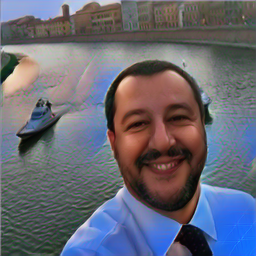

In [67]:
resimg

In [ ]:
real = transforms.functional.resize(PIL.Image.open('ronaldo.jpg'), (256, 256))

In [ ]:
np.array(resimg)[0][:5]

In [ ]:
np.linalg.norm(np.array(real) - np.array(resimg))

In [ ]:
#PIL.Image.open('ronaldo.jpg')

In [ ]:
nets = torch.load('savedpytorchnet_epoch2_loss59946880.0.pt')

In [ ]:
res = nets(testimage)

In [ ]:
prova = torch.randn(1, 32, 200, 200)
res = (torch.tanh(nn.Conv2d(32, 3, 9, padding=4)(prova))+1)*127.5

In [ ]:
net = torch.load('savedpytorchnet_epoch1_loss61.405765533447266.pt')